In [9]:
from cnn_utils import confusion_plot

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten, Dropout

In [6]:
# Reading the cvs file:
traindata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')
valdata = pd.read_csv('val.csv')

# loading images from folder directory
img_dir = os.path.join(os.getcwd(), 'archive')

# class/label structure
gender_dict = {0: 'male', 1: 'female'}

# The data in the column where the label is located is not of string type and needs to be converted
traindata['gender'] = traindata['gender'].astype(str)  
testdata['gender'] = testdata['gender'].astype(str) 
valdata['gender'] = valdata['gender'].astype(str) 

datagen = ImageDataGenerator()
# training set data generator
train_gen = datagen.flow_from_dataframe(
    dataframe=traindata,
    directory='archive', # directory to image folder
    x_col='img_name', # csvheader for image filenames
    y_col='gender', # csvheader for labels
    color_mode='rgb',
    target_size=(40, 40), # input image size
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical') # raw: without converting y, categorical:, binary:

# test set data generator
test_gen = datagen.flow_from_dataframe(
    dataframe=testdata,
    directory='archive',
    x_col='img_name',
    y_col='gender',
    color_mode='rgb',
    target_size=(40, 40),
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='categorical')

# validation set data generator
val_gen = datagen.flow_from_dataframe(
    dataframe=valdata,
    directory='archive',
    x_col='img_name',
    y_col='gender',
    color_mode='rgb',
    target_size=(40, 40),
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='categorical')

Found 15171 validated image filenames belonging to 2 classes.
Found 4741 validated image filenames belonging to 2 classes.
Found 3793 validated image filenames belonging to 2 classes.


In [3]:
def get_model():
    
    # config param
    lr = 0.001
    nb_filters = 32
    kernel_size = (3, 3)
    pool_size = (2, 2)
    activ_func = 'relu'
    drop = 0.3
    
    # input layer
    input_layer = Input(shape=(40, 40, 3))
    
    # first convolution layer
    x = Conv2D(filters=nb_filters,kernel_size=kernel_size,activation=activ_func)(input_layer)
    x = Conv2D(filters=nb_filters,kernel_size=kernel_size,activation=activ_func)(x)
    x = MaxPooling2D(pool_size)(x)
    
    # second convolution layer
    x = Conv2D(filters=nb_filters,kernel_size=kernel_size,activation=activ_func)(x)
    x = Conv2D(filters=nb_filters,kernel_size=kernel_size,activation=activ_func)(x)
    x = MaxPooling2D(pool_size)(x)
    
    # fully connected layers
    x = Flatten()(x)
    x = Dense(1000,activation=activ_func)(x)
    x = Dropout(drop)(x)
    x = Dense(500,activation='relu')(x)
    x = Dropout(drop)(x)
    
    # output: predictions
    output = Dense(2, activation="softmax")(x)
    
    # assemble model
    CNN_model = Model(input_layer, output)
    
    # optimizer
    optimizer = keras.optimizers.SGD(lr=lr,momentum=0.9)

    # compile model
    CNN_model.compile(loss=["categorical_crossentropy"],optimizer='adam',metrics=["accuracy"])
    
    return CNN_model

# steps sizes
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size+1

# train model on train set
epochs = 10
model = get_model()

# save training output
summary_file = 'summary.txt'
logger_file = 'training.log'
csv_logger = CSVLogger(logger_file)
print('Save logger file: %s ' % logger_file)

# model structure in summary
print(model.summary())

# train model 
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[csv_logger])

# get training metrices
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Save model and weights
model_file = 'model.h5'
model_path = os.path.join(os.getcwd(), model_file)
model.save(model_path)
print('Save trained model: %s ' % model_file)

# predict on test set
y_true = test_gen.labels
y_pred = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)

Save logger file: training.log 
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 38, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPo

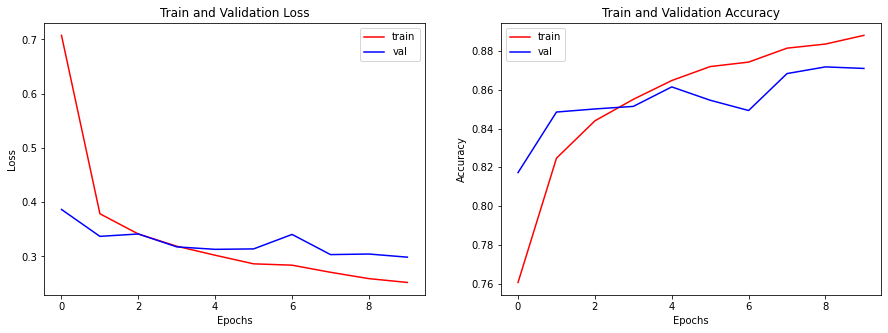

In [4]:
# plot metrices
f, axs = plt.subplots(1,2)

# plot losses
axs[0].plot(train_loss, color='r')
axs[0].plot(val_loss, color='b')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title('Train and Validation Loss')
axs[0].legend(['train', 'val'])


# plot accuracies
axs[1].plot(train_acc, color='r')
axs[1].plot(val_acc, color='b')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title('Train and Validation Accuracy')
axs[1].legend(['train', 'val'])

f.set_size_inches(15,5)
plt.show()

Confusion Matrix:
[[2208  270]
 [ 350 1913]]


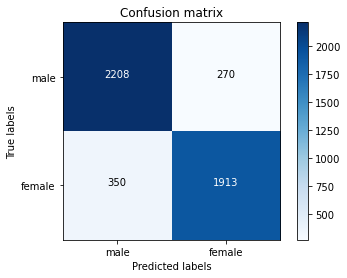

In [7]:
# plot confusion matrix with total numbers
classes = gender_dict.values()
confusion_plot(y_true, y_pred, classes, normalized=False)
plt.show()

Normalized Confusion Matrix:
[[89.10411622 10.89588378]
 [15.46619532 84.53380468]]


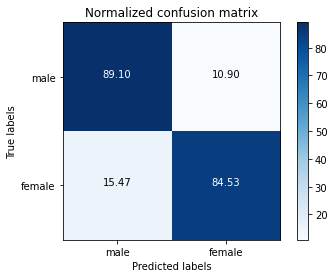

In [8]:
# plot normalized confusion matrix
confusion_plot(y_true, y_pred, classes, normalized=True)
plt.show()